# 01-3 패션 상품 이미지 분류하기

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/01-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## LetNet 모델 만들기

### 시그모이드 함수와 렐루 함수

시그모이드 함수: $f(x) = \dfrac{1}{1+e^{-x}}$

렐루 함수: $f(x) = \begin{cases}
                    \mbox{max}(0, x), & x\mbox{ >= 0 이면} \\
                    0,                & x\mbox{ < 0 이면}
                 \end{cases}$

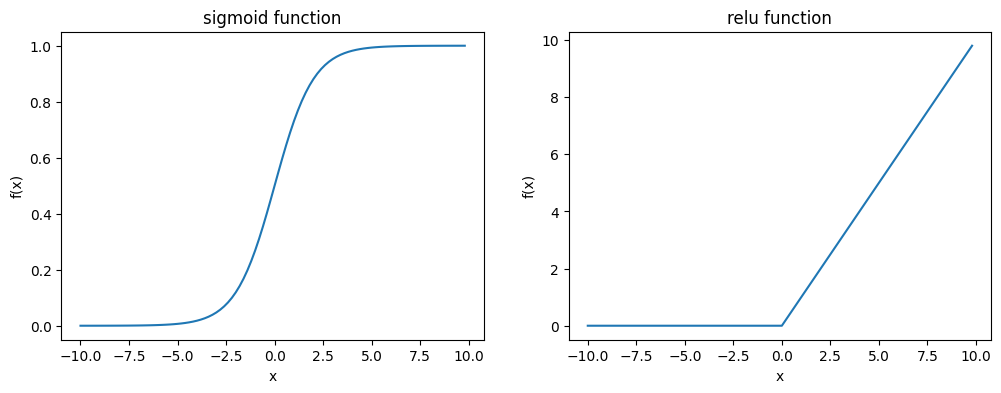

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

x = np.arange(-10, 10, 0.2)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x, expit(x))
axs[0].set_title('sigmoid function')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[1].plot(x, x.clip(0))
axs[1].set_title('relu function')
axs[1].set_xlabel('x')
axs[1].set_ylabel('f(x)')
plt.show()

In [ ]:
import keras
from keras import layers

In [ ]:
lenet5 = keras.Sequential()
lenet5.add(layers.Input(shape=(28, 28, 1)))
lenet5.add(layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                         padding='same'))
lenet5.add(layers.AveragePooling2D(pool_size=2))
lenet5.add(layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid'))
lenet5.add(layers.AveragePooling2D(pool_size=2))
lenet5.add(layers.Flatten())
lenet5.add(layers.Dense(120, activation='sigmoid'))
lenet5.add(layers.Dense(84, activation='sigmoid'))
lenet5.add(layers.Dense(10, activation='softmax'))

## LeNet 모델 훈련하기

소프트맥스 함수: $f(x)_i = \dfrac{e^{z_i}}{\sum_{j=1}^{k}e^{z_j}}$

$f(x) = \dfrac{e^{z_1}+e^{z_2}+...+e^{z_k}}{\sum_{j=1}^{k}e^{z_j}}=1$

In [ ]:
lenet5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

### 훈련 데이터 준비하기

In [ ]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(train_target)

[9 0 0 ... 3 0 5]


In [ ]:
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


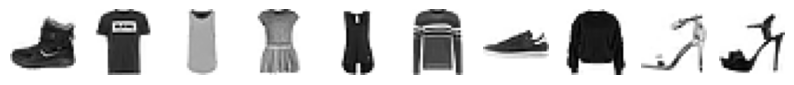

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    axs[i].imshow(train_input[i], cmap='gray_r')
    axs[i].axis('off')
plt.show()

In [ ]:
train_input = train_input.reshape(-1, 28, 28, 1) / 255.0

In [ ]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

### 모델 훈련하기

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('lenet5-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

In [ ]:
lenet5.compile(loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
hist = lenet5.fit(train_scaled, train_target, epochs=20,
                  validation_data=(val_scaled, val_target),
                  callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4182 - loss: 1.5683 - val_accuracy: 0.7251 - val_loss: 0.7157
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7425 - loss: 0.6649 - val_accuracy: 0.7249 - val_loss: 0.6696
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7715 - loss: 0.5875 - val_accuracy: 0.7841 - val_loss: 0.5689
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7974 - loss: 0.5368 - val_accuracy: 0.7985 - val_loss: 0.5250
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8170 - loss: 0.4843 - val_accuracy: 0.8294 - val_loss: 0.4594
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8345 - loss: 0.4494 - val_accuracy: 0.8373 - val_loss: 0.4368
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8425 - loss: 0.4252 - val_accuracy: 0.8369 - val_loss: 0.4409
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8463 - loss: 0.4100

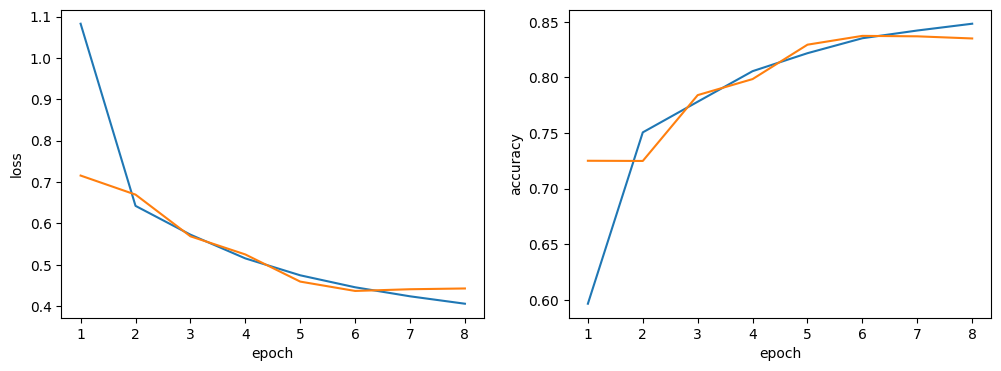

In [ ]:
epochs = range(1, len(hist.history['loss'])+1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(epochs, hist.history['loss'])
axs[0].plot(epochs, hist.history['val_loss'])
axs[0].set_xticks(epochs)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[1].plot(epochs, hist.history['accuracy'])
axs[1].plot(epochs, hist.history['val_accuracy'])
axs[1].set_xticks(epochs)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
plt.show()